# Logarithms and heteroskedasticity

Here's a [question from the Reddit statistics forum](https://www.reddit.com/r/statistics/comments/1czsban/eq_is_it_correct_to_use_logarithmic/).

> Is it correct to use logarithmic transformation in order to mitigate heteroskedasticity? 
>
> Hello everyone. For my studies I gathered data on certain preferences across a group of people. I am trying to figure out if I can pinpoint preferences to factors such as gender in this case.
>
> I used mixed ANOVA analysis with good success however one of my hypothesis came up with heteroskedasticity when doing Levene's test. I breaking my head all day on how to solve this. I've now used logarithmic transformation to all 3 test results and run another Levene's. When using the media value the test now results [in] homoskedasticity, however interaction is no longer significant?
>
> Is this the correct way to deal with this problem or is there something I am missing? Thanks in advance to everyone taking their time to help.

Although the question is about ANOVA, I'm going to reframe it in terms of regression, for two reasons:

* Discussion of heteroskedasticity is clearer in the context of regression.

* For many problems, a regression model is better than ANOVA anyway.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/DataQnA/blob/main/nb/log_heterosked.ipynb).

I'll download a utilities module with some of my frequently-used functions, and then import the usual libraries.

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + str(local))
    return filename

download('https://github.com/AllenDowney/DataQnA/raw/main/nb/utils.py')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from utils import decorate

In [2]:
# install the empiricaldist library, if necessary

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

## What is heteroskedasticity?

Linear regression is based on a model of the data-generating process where the independent variable $y$ is the sum of

* A linear function of $x$ with an unknown slope and intercept, and

* Random values drawn from a Gaussian distribution with mean $\mu=0$ and unknown standard deviation, $\sigma$, that does not depend on $x$.

So what happens if we violate these assumptions?

* If $y$ is a non-linear function of $x$, regression finds the best linear fit to the data, which might not be very good.

* If $\mu$ is not zero and it does not depend on $x$, the estimate of the intercept will be biased.

* If $\mu$ is not zero and it *does* depend on $x$, the estimate of the slope will be biased, and probably the intercept, too.

* If $\sigma$ depends on $x$, the data-generating process is heteroskedastic. In general, heteroskedasticity doesn't bias the slope or the intercept, but it might bias the standard error of the estimated parameters.

Right off the bat, we see one reason not to worry much about heteroskedasticity: it doesn't bias the estimated parameters of the model, only the standard errors.
And we really don't need standard errors to be particularly precise.

Now let's see a second reason not to worry much about heteroskedasticity: even very strong heteroskedasticity doesn't affect the standard errors by much.

To demonstrate, I'll generate some data.
First, we'll draw `xs` from a normal distribution.

In [3]:
np.random.seed(17)

xs = np.random.normal(30, 1, size=200)
xs.sort()

If `sigma` is constant, the model is homoskedastic.

In [4]:
sigma = 3
ys = xs + np.random.normal(0, sigma, size=len(xs))

To generate heteroskedastic data, I'll use `interpolate` to construct a function where `sigma` depends on `x`.

In [5]:
from scipy.interpolate import interp1d

def interpolate(xs, sigma_seq):
    return interp1d([xs.min(), xs.max()], sigma_seq)(xs)

To generate strong heteroskedasticity, I'll vary sigma over a wide range.

In [6]:
sigmas = interpolate(xs, [0.1, 6.0])
np.mean(sigmas)

3.126391153924031

Here's what `sigma` looks like as a function of `x`.

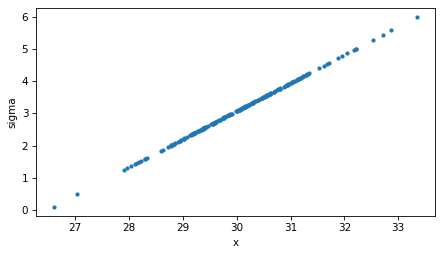

In [7]:
plt.plot(xs, sigmas, '.')

decorate(xlabel='x',
         ylabel='sigma')

Now we can generate `ys` with variable values of `sigma`.

In [8]:
ys = xs + np.random.normal(0, sigmas)

If we make a scatter plot of the data, we see a cone shape that is indicative of heteroskedasticity.

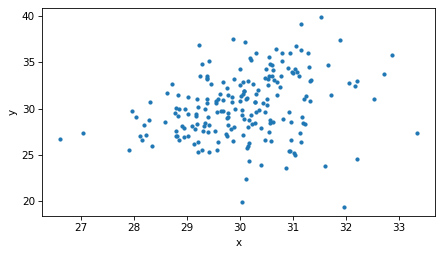

In [9]:
plt.plot(xs, ys, '.')

decorate(xlabel='x', ylabel='y')

Now let's fit a model to the data.

In [10]:
import statsmodels.api as sm

X = sm.add_constant(xs)
ols_model = sm.OLS(ys, X)
ols_results = ols_model.fit()

intercept, slope = ols_results.params
intercept, slope

(3.388094635972095, 0.8937621786255208)

Here's what the fitted line looks like.

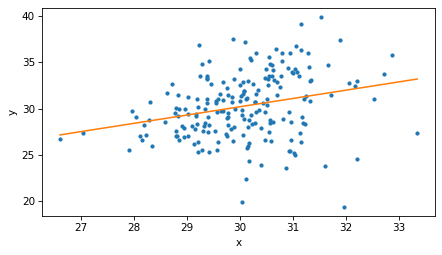

In [11]:
fys = intercept + slope * xs

plt.plot(xs, ys, '.')
plt.plot(xs, fys)

decorate(xlabel='x', ylabel='y')

If we plot the absolute values of the residuals, we can see the heteroskedasticity more clearly.

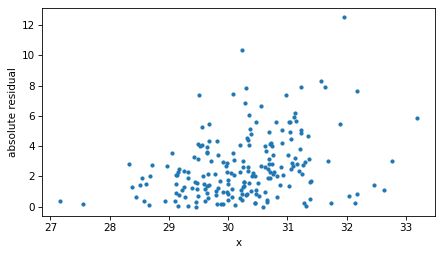

In [12]:
resid = ys - fys
plt.plot(fys, np.abs(resid), '.')

decorate(xlabel='x', ylabel='absolute residual')

## Testing for heteroskedasticity

OP mentions using the Levene test for heteroskedasticity, which is used to test whether variability is different between groups.
For continuous values of `x` and `y`, we can use the Breusch-Pagan Lagrange Multiplier test:

In [13]:
from statsmodels.stats.diagnostic import het_breuschpagan

_, p_value, _, _ = het_breuschpagan(resid, ols_model.exog)
p_value

2.9400325716458528e-05

Or White’s Lagrange Multiplier test:

In [14]:
from statsmodels.stats.diagnostic import het_white

_, p_value, _, _ = het_white(resid, ols_model.exog)
p_value

0.00014557228244861052

Both tests produce very small p-values, which means that if we generate a dataset by a homoskedastic process, there is almost no chance it would have as much heteroskedasticity as the dataset we generated.

If you have never heard of either of these tests, don't panic -- neither had I under I looked them up for this example.
And don't worry about remembering them, because you should never use them again.
Like testing for normality, testing for heteroskedasticity is never useful.

Why? Because in almost any real dataset, you will find some heteroskedasticity.
So if you test for it, there are only two possible results:

* If the heteroskedasticity is small and you don't have much data, you will fail to reject.

* If the heteroskedasticity is large or you have a lot of data, you will reject.

Either way, you learn nothing.
And in particular, you don't learn the answer to the question you actually care about, which is whether the heteroskedasticity is so large that the effect on the standard errors is large enough that you care.

And the answer to that questions is almost always no.




## Should we care?

In the example, I generated data with a very large heteroskedasticity. Let's see how much effect that has on the results.
Here are the standard errors from the simple linear regression:

In [15]:
ols_results.bse

array([6.94113977, 0.23077194])

Now, there are several ways to generate standard errors that are robust in the presence of heteroskedasticity.
One is the Huber-White estimator, which we can compute like this:

In [16]:
robust_se = ols_results.get_robustcov_results(cov_type='HC3')
robust_se.bse

array([7.31187309, 0.24686819])

Another is to use Huber regression.

In [17]:
huber_model = sm.RLM(ys, X, M=sm.robust.norms.HuberT())
huber_results = huber_model.fit()
huber_results.bse

array([6.75285441, 0.22451202])

And yet another is to use quantile regression.

In [18]:
quantile_model = sm.QuantReg(ys, X)
quantile_results = quantile_model.fit(q=0.5)
quantile_results.bse

array([8.63698842, 0.28715379])

Let's put those results in a table.

In [19]:
columns = ['SE(intercept)', 'SE(slope)']
index = ['OLS', 'robust SE', 'Huber', 'Quantile']
data = [ols_results.bse, robust_se.bse, huber_results.bse, quantile_results.bse]
df = pd.DataFrame(data, columns=columns, index=index)
df.sort_values(by='SE(slope)')

,SE(intercept),SE(slope)
Huber,6.752854,0.224512
OLS,6.941140,0.230772
robust SE,7.311873,0.246868
Quantile,8.636988,0.287154


The results from Huber regression and OLS are very similar.
The robust standard errors and the results from quantile regression are notably higher, which might be some cause for concern.
But even in this example where the heteroskedasticity is substantial, the difference in the standard errors probably don't matter much -- for practical purposes, we don't need standard errors to be particularly precise.

In my opinion, you can forget about esoteric methods for dealing with heteroskedasticity. Just use ordinary least squares.

Now let's address OP's headline question, "Is it correct to use logarithmic transformation in order to mitigate heteroskedasticity?"


## Log transform help?

In some cases, a log transform can reduce or eliminate heteroskedasticity. However, there are several reasons this is not a good idea in general:

* As we've seen, heteroskedasticity is not a big problem, so it usually doesn't require any mitigation.

* Taking a log transform doesn't always help.

* Taking a log transform of one or more variables in a regression model changes the meaning of the model -- it hypothesizes a different relationship between the variables that might not  make sense in context.

To demonstrate the second point, let's see what happens if we apply a log transform to the dependent variable:

In [20]:
lys = np.log10(ys)

Here's what the scatter plot looks like after the transform.

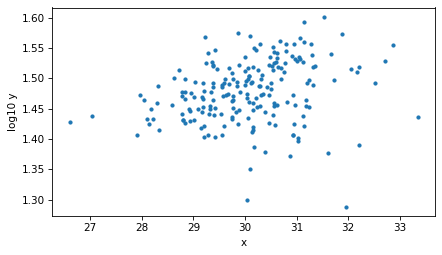

In [21]:
plt.plot(xs, lys, '.')

decorate(xlabel='x', ylabel='log10 y')

Here's what we get if we fit a model to the data.

In [22]:
X = sm.add_constant(xs)
ols_model = sm.OLS(lys, X)
ols_results = ols_model.fit()

intercept, slope = ols_results.params
intercept, slope

(1.1237964079702256, 0.011777374792320695)

And here's the fitted line.

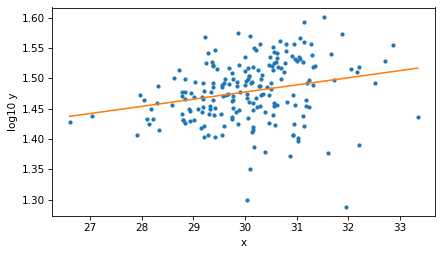

In [23]:
fys = intercept + slope * xs

plt.plot(xs, lys, '.')
plt.plot(xs, fys)

decorate(xlabel='x', ylabel='log10 y')

If we plot the absolute values of the residuals, we can see that the log transform did not entirely remove the heteroskedasticity.

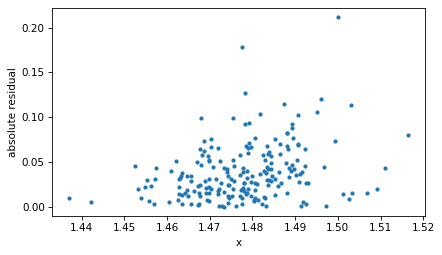

In [24]:
resid = lys - fys
plt.plot(fys, np.abs(resid), '.')

decorate(xlabel='x', ylabel='absolute residual')

Which we can confirm by running the tests again (which we should never do).

In [25]:
_, p_value, _, _ = het_breuschpagan(resid, ols_model.exog)
p_value

0.0002697763744132208

In [26]:
_, p_value, _, _ = het_white(resid, ols_model.exog)
p_value

0.0011617542598402885

The p-values are a few orders of magnitude bigger, which suggests that the log transform mitigated the heteroskedasticity a little.
But if the goal was to eliminate heteroskedasticity, the log transform didn't do it.

## Discussion

To summarize:

* Heteroskedasticity is common in real datasets -- if you test for it, you will often find it, provided you have enough data.

* Either way, testing for heteroskedasticity does not answer the question you really care about, which is whether the heteroskedasticity is severe enough to be a problem.

* Plain old linear regression is quite robust to heteroskedasticity, so unless it is really extreme, it is probably not a problem.

* Even in the worst case heteroskedasticity does not bias the estimated parameters -- it only biases the standard errors. And we don't need standard errors to be particularly precise anyway.

* Although a log transform can sometimes mitigate heteroskedasticity, it doesn't always succeed, and even if it does, it's usually not necessary.

* What a log transform *does* do is change the meaning of the regression model in ways that might not make sense in context.

So, use a log transform if it makes sense in context, not to mitigate a problem that's not much of a problem in the first place.

[*Data Q&A: Answering the real questions with Python*](https://allendowney.github.io/DataQnA/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)